In [1]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, skip=False):
        super(Bottleneck, self).__init__()
        self.skip = skip
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=False)
        self.downsample = None
        if stride != 1 or in_planes != self.expansion * planes:
            self.downsample = nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out = out + identity
        return self.relu(out)

class CustomResNet50(nn.Module):
    def __init__(self, skip=False):
        super(CustomResNet50, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3, skip)
        self.layer2 = self._make_layer(128, 4, skip, stride=2)
        self.layer3 = self._make_layer(256, 6, skip, stride=2)
        self.layer4 = self._make_layer(512, 3, skip, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, 10)

    def _make_layer(self, planes, blocks, skip, stride=1):
        layers = [Bottleneck(self.in_planes, planes, stride, skip)]
        self.in_planes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_planes, planes, skip=skip))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CustomResNet50(skip=False).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

selected_layers = ["conv1", "layer1.0.conv1", "layer2.0.conv2", "layer3.5.conv3", "fc"]
gradients = {}

def register_hooks(model):
    for name, module in model.named_modules():
        if name in selected_layers and (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)):
            gradients[name] = []
            def hook(module, grad_input, grad_output, name=name):
                gradients[name].append(grad_output[0].norm().item())
            module.register_full_backward_hook(hook)

register_hooks(model)

In [2]:
def train(model, epochs=1):
    model.train()
    for epoch in tqdm(range(epochs)):
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

train(model, epochs=10)

100%|██████████| 10/10 [12:11<00:00, 73.11s/it]


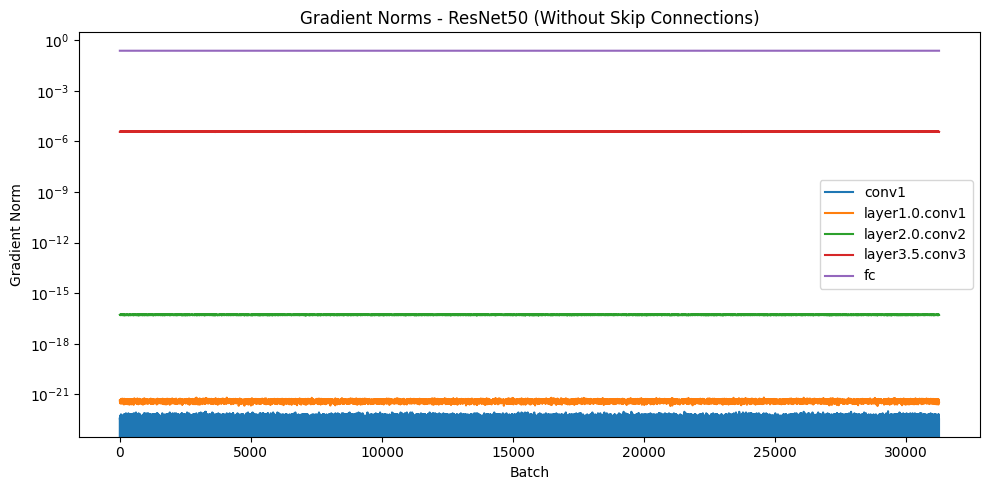

In [3]:
# Plot filtered gradients
plt.figure(figsize=(10, 5))
for name, values in gradients.items():
    if len(values) > 0:
        plt.plot(values, label=name)
plt.title("Gradient Norms - ResNet50 (Without Skip Connections)")
plt.xlabel("Batch")
plt.ylabel("Gradient Norm")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
import json

with open("outputs/gradients_resnet50_without_skip.json", "w") as f:
    json.dump(gradients, f)